## `RandomSequencesTest` with `PredictiveAsymmetryTest`

In [44]:
using UncertainData, CausalityTools, Plots, Distributions, Test, StatsBase

## Example system

Let's use a nonlinearly coupled 3D system to generate time series. 

In [45]:
?nonlinear3d

search: nonlinear3d eom_nonlinear3d random_nonlinear3d



```
nonlinear3d(;uᵢ = rand(3), 
    σ₁ = 1.0, σ₂ = 1.0, σ₃ = 1.0, 
    a₁ = 3.4, a₂ = 3.4, a₃ = 3.4, 
    b₁ = 0.4, b₂ = 0.4, b₃ = 0.4, 
    c₁₂ = 0.5, c₂₃ = 0.3, c₁₃ = 0.5) -> DiscreteDynamicalSystem
```

A 3d nonlinear system with nonlinear couplings $x_1 \to x_2$,  $x_2 \to x_3$ and $x_1 \to x_3$. Modified from [1]. 

## Equations of motion

The equations of motion are

$$
\begin{aligned}
x_1(t+1) &= a_1 x_1 (1-x_1(t))^2  e^{-x_2(t)^2} + 0.4 \xi_{1}(t) \\
x_2(t+1) &= a_1 x_2 (1-x_2(t))^2  e^{-x_2(t)^2} + 0.4 \xi_{2}(t) + b x_1 x_2 \\
x_3(t+1) &= a_3 x_3 (1-x_3(t))^2  e^{-x_3(t)^2} + 0.4 \xi_{3}(t) + c x_{2}(t) + d x_{1}(t)^2.
\end{aligned}
$$

## References

1. Gourévitch, B., Le Bouquin-Jeannès, R., & Faucon, G. (2006). Linear and nonlinear   causality between signals: methods, examples and neurophysiological   applications. Biological Cybernetics, 95(4), 349–369.


## Randomising parameters

Let's generate a function that randomises the parameters for the system.

In [46]:
function random_nonlinear3d(;
        uᵢ = rand(3),
        c₁₂ = 0.5, c₂₃ = 0.3, c₁₃ = 0.5,
        σ₁ = rand(Uniform(0.5, 1.0)), σ₂ = rand(Uniform(0.5, 1.0)), σ₃ = rand(Uniform(0.5, 1.0)),
        a₁ = rand(Uniform(3.1, 3.8)), a₂ = rand(Uniform(3.1, 3.8)), a₃ = rand(Uniform(3.1, 3.8)),
        b₁ = rand(Uniform(0.2, 0.8)), b₂ = rand(Uniform(0.2, 0.8)), b₃ = rand(Uniform(0.2, 0.8)))
    
    return nonlinear3d(
        σ₁ = σ₁, σ₂ = σ₂, σ₃ = σ₃, 
        a₁ = a₁, a₂ = a₂, a₃ = a₃, 
        b₁ = b₁, b₂ = b₂, b₃ = b₃, 
        c₁₂ = c₁₂, c₂₃ = c₁₂, c₁₃ = c₁₂,
        uᵢ = uᵢ
        )
end

random_nonlinear3d (generic function with 14 methods)

Now, each time we call `random_nonlinear3d`, we'll get a different dynamical system starting at random initial conditions.

## Adding uncertainties to the system

In [48]:
# Time series length
N = 300

# Initalise a system
sys = random_nonlinear3d(c₁₂ = 0.5)

# We'll select the first and second components and add uncertainties 
# to both the indices and the values.
X, Y = example_uncertain_indexvalue_datasets(sys, N, (1, 2), tstep = 5,
    d_xval = Uniform(0.001, 0.2), d_yval = Uniform(0.001, 0.2),
    d_xind = Uniform(0.001, 2), d_yind = Uniform(0, 2));

## Defining causality test

First, define a predictive asymmetry test.

In [ ]:
k, l, m = 1, 1, 1
ηs = -5:5
n_subdivs = floor(Int, N^(1/(k + l + m + 1)))
te_test = VisitationFrequencyTest(k = k, l = l, m = m, 
    binning = RectangularBinning(n_subdivs), ηs = ηs)
pa_test = PredictiveAsymmetryTest(predictive_test = te_test)

Now, decide on how the random chunks should be draws. We'll sample 100 chunks ranging in length from `N-30` to `N-2`.

In [54]:
r = RandomSequences(100, N-30:N-2);

Now, combine the random chunks resampling with our predictive asymmetry causality test.

In [53]:
test = RandomSequencesTest(pa_test, r)

RandomSequencesTest{PredictiveAsymmetryTest{VisitationFrequencyTest},RandomSequences}(PredictiveAsymmetryTest{VisitationFrequencyTest}(predictive_test = VisitationFrequencyTest(k = 1, l = 1, m = 1, n = 1, τ = 1, b = 2, binning_summary_statistic = mean, estimator = VisitationFrequency(), binning = RectangularBinning(4), ηs = -5:5)), RandomSequences(100, 270:298))

## Perform causality test on random chunks and plot

Now, we're ready to perform the causality test.

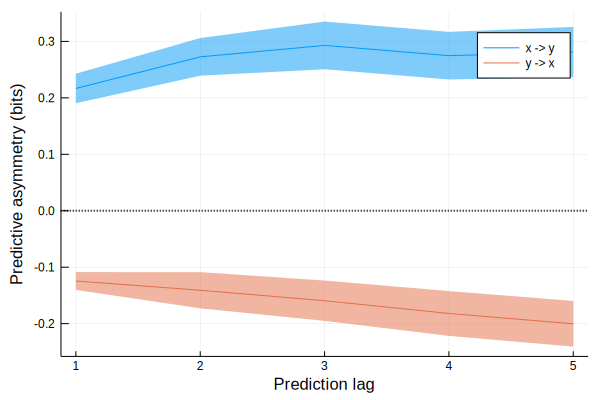

In [56]:
res_xy = causality(X, Y, test)
res_yx = causality(Y, X, test);

# Plot
RES_xy = hcat(res_xy...)
RES_yx = hcat(res_yx...);
plot(xlabel = "Prediction lag", ylabel = "Predictive asymmetry (bits)")
plot!(1:maximum(ηs), mean(RES_xy, dims = 2), ribbon = std(RES_xy, dims = 2), label = "x -> y")
plot!(1:maximum(ηs), mean(RES_yx, dims = 2), ribbon = std(RES_yx, dims = 2), label = "y -> x")
hline!([0], label = "", ls = :dot, lw = 2, c = :black)

For most of the realisations, $\mathbb{A}_{x \to y}$ is clearly positive across prediction lags, while $\mathbb{A}_{y \to x}$. Hence, the predictive asymmetry relatively consistently detects the underlying causal directional coupling!